In [21]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import dotenv_values, find_dotenv
import os
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import iip_dataclean
import importlib
importlib.reload(iip_dataclean)
from iip_dataclean import iip_dataclean, filter_data_heatmap

# this looks for your configuration file and then reads it as a dictionary
config = dotenv_values(find_dotenv())

# set path using the dictionary key for which one you want
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_rawdata = os.path.abspath(config["RAWDATA"]) + '\\'
path_imfdata = os.path.abspath(config["IMFDATA"]) + '\\'
path_figures = os.path.abspath(config["FIGURES"]) + '\\'

plt.rcParams.update({'font.size': 12})

In [23]:
# some previously collected data
# note: 'gdp' is nominal gdp in usd
portfoliodata = pd.read_pickle( path_cleandata + "PortfolioData_interestrates_wICIO.pkl")
portfoliodata = portfoliodata[['iso3', 'Date', 'year', 'gdp', 'spot', 'fwd1', 'policyrate', 'shortterm']]

# country codes
imf_codes = pd.read_csv(path_rawdata + "Country_iso_codes.csv")

# iip data
iip_usd = pd.read_csv(path_imfdata + 'BOP_data_USD.csv', low_memory=False)
iip_euro = pd.read_csv(path_imfdata + 'BOP_data_EURO.csv', low_memory=False)
iip_home = pd.read_csv(path_imfdata + 'BOP_data_DOMESTIC.csv', low_memory=False)

iip_usd_long = iip_dataclean(iip_usd)
iip_euro_long = iip_dataclean(iip_euro)
iip_home_long = iip_dataclean(iip_home)

In [3]:
# cpis data (plus a LOT of data cleaning steps)
cpis = pd.read_csv(path_imfdata + 'CPIS_data.csv', low_memory=False)

# add iso3 codes in order to merge data
iso3_map = imf_codes.set_index('IMF').to_dict()['iso3']
cpis['iso3_o']= cpis['Country Code'].map(iso3_map)
cpis['iso3_c']= cpis['Counterpart Country Code'].map(iso3_map)

# fill euro value
cpis.loc[cpis['Country Name'] == 'Euro Area', 'iso3_o'] = 'EUR'
cpis.loc[cpis['Counterpart Country Name'] == 'Euro Area', 'iso3_c'] = 'EUR'

# drop unused columns
cpis = cpis.drop(['Country Name', 'Country Code', 'Counterpart Country Name', 'Counterpart Country Code', 
                  'Counterpart Sector Name', 'Counterpart Sector Code', 
                  'Sector Name', 'Sector Code', 'Attribute', 'Unnamed: 67'], axis=1)
# these are columns that just show a duplicate of whatever the annual value is so they can just be dropped
cpis = cpis.drop(list(cpis.filter(regex = 'S2')), axis = 1)
# drop any unmatched IMF codes
cpis = cpis.loc[(cpis['iso3_c'].notnull()) & (cpis['iso3_o'].notnull())]

# Specify the columns to keep as identifiers
id_vars = ['Indicator Name', 'Indicator Code', 'iso3_o', 'iso3_c']

# Use the melt function to convert the DataFrame to long format
cpis_long = pd.melt(cpis, id_vars=id_vars, var_name='date', value_name='value')

# remove the weird strings by just changing them to nan
cpis_long.loc[cpis_long['value'] == 'C', 'value'] = np.nan
cpis_long.loc[cpis_long['value'] == '-', 'value'] = np.nan
# i'm considering zeros as nans as well just based on how the zeros are distributed
cpis_long.loc[cpis_long['value'] == '0', 'value'] = np.nan
# change value column to numeric
cpis_long['value'] = pd.to_numeric(cpis_long['value'])

# for some reason the values in each country pair and time period show up across two rows so i need to squish them down
cpis_long = cpis_long.groupby(['Indicator Name', 'Indicator Code', 'iso3_o', 'iso3_c', 'date']).sum(min_count=1).reset_index()
cpis_long = cpis_long.fillna(value=np.nan)

# make two cpis dataframes (grouping by both sets of countries)
cpis_grouped_o = cpis_long.groupby(['Indicator Name', 'Indicator Code', 'iso3_o', 'date'], as_index=False)['value'].sum(min_count=1)
cpis_grouped_o.rename(columns={'iso3_o': 'iso3'}, inplace=True)
cpis_grouped_c = cpis_long.groupby(['Indicator Name', 'Indicator Code', 'iso3_c', 'date'], as_index=False)['value'].sum(min_count=1)
cpis_grouped_o.rename(columns={'iso3_c': 'iso3'}, inplace=True)

Data availability:

IIP data:
- IA_BP6_USD: Assets, Total, US Dollars
- IA_BP6_EUR: Assets, Total, Euros
- IA_BP6_XDC: Assets, Total, National Currency
- IL_BP6_USD: Liabilities, Total, US Dollars
- IL_BP6_EUR: Liabilities, Total, Euros
- IL_BP6_XDC: Liabilities, Total, National Currency

CPIS data:
- I_A_T_T_T_BP6_USD: Assets, Total Investment, BPM6, US Dollars, grouped by country
- I_A_T_T_T_BP6_USD: Assets, Total Investment, BPM6, US Dollars, grouped by counterpart country
- I_L_T_T_T_BP6_USD: Liabilities, Total Investment, BPM6, US Dollars, grouped by country
- I_L_T_T_T_BP6_USD: Liabilities, Total Investment, BPM6, US Dollars, grouped by counterpart country


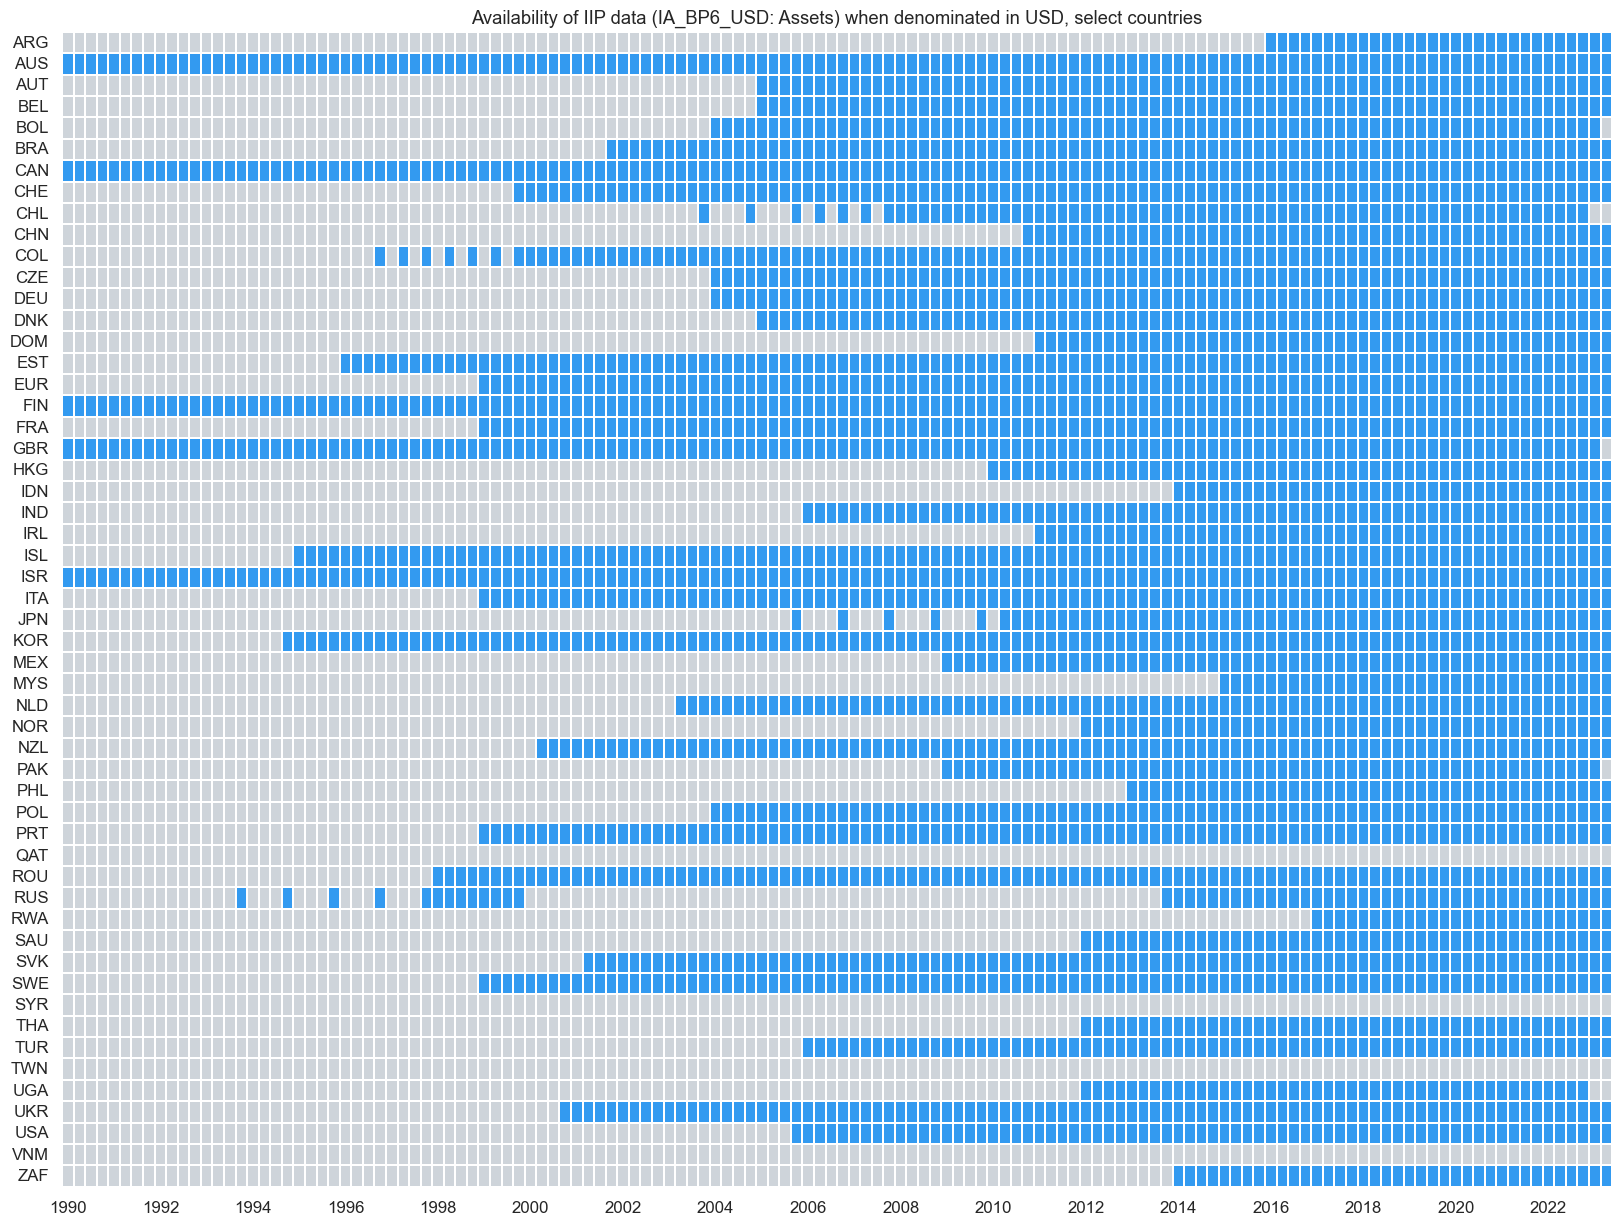

,iso3,date,value
5,AUS,1990-01-31,8.503002e+10
6,ARG,1990-01-31,NaN
9,AUT,1990-01-31,NaN
10,BEL,1990-01-31,NaN
14,BOL,1990-01-31,NaN
...,...,...,...
18219,SYR,2014-07-31,NaN
18220,SYR,2020-01-31,NaN
18221,SYR,1996-04-30,NaN
18222,SYR,2019-10-31,NaN


In [17]:
filter_data_heatmap(iip_usd_long, 'IA_BP6_USD')

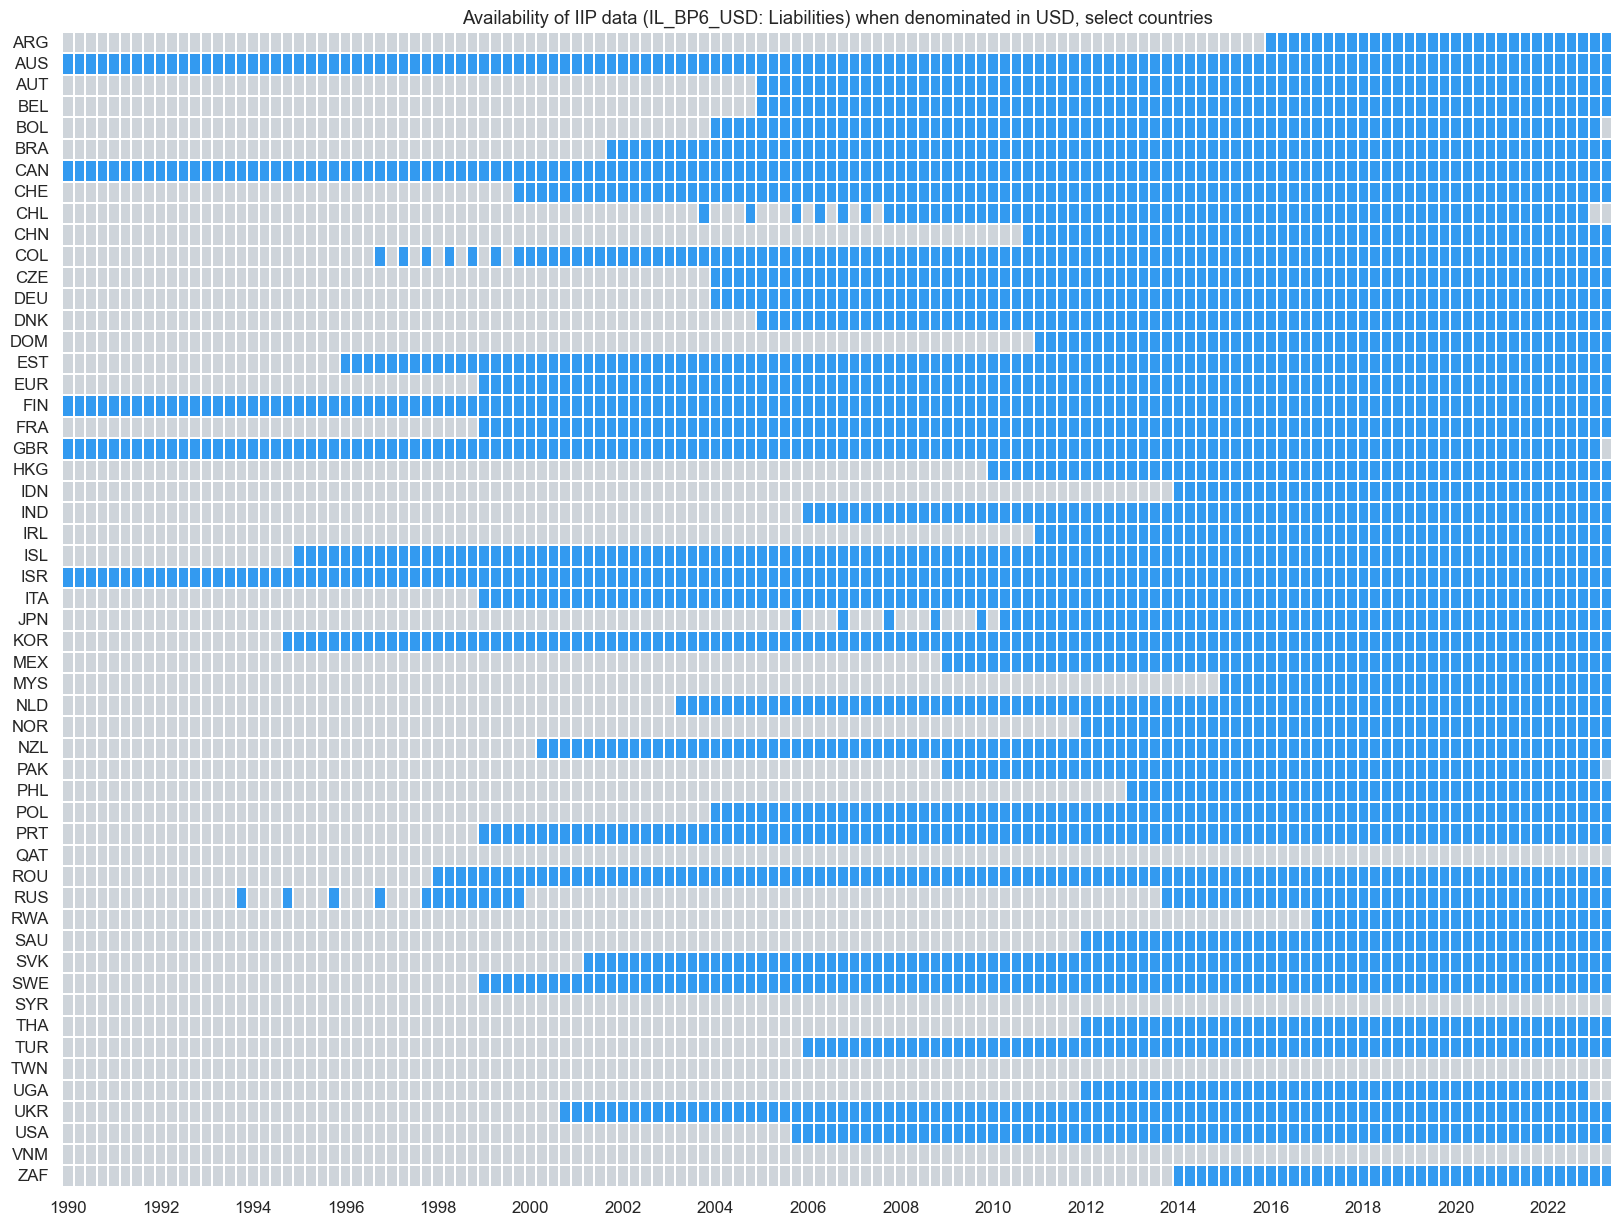

,iso3,date,value
5,AUS,1990-01-31,2.143014e+11
6,ARG,1990-01-31,NaN
9,AUT,1990-01-31,NaN
10,BEL,1990-01-31,NaN
14,BOL,1990-01-31,NaN
...,...,...,...
18219,SYR,2014-07-31,NaN
18220,SYR,2020-01-31,NaN
18221,SYR,1996-04-30,NaN
18222,SYR,2019-10-31,NaN


In [18]:
filter_data_heatmap(iip_usd_long, 'IL_BP6_USD')

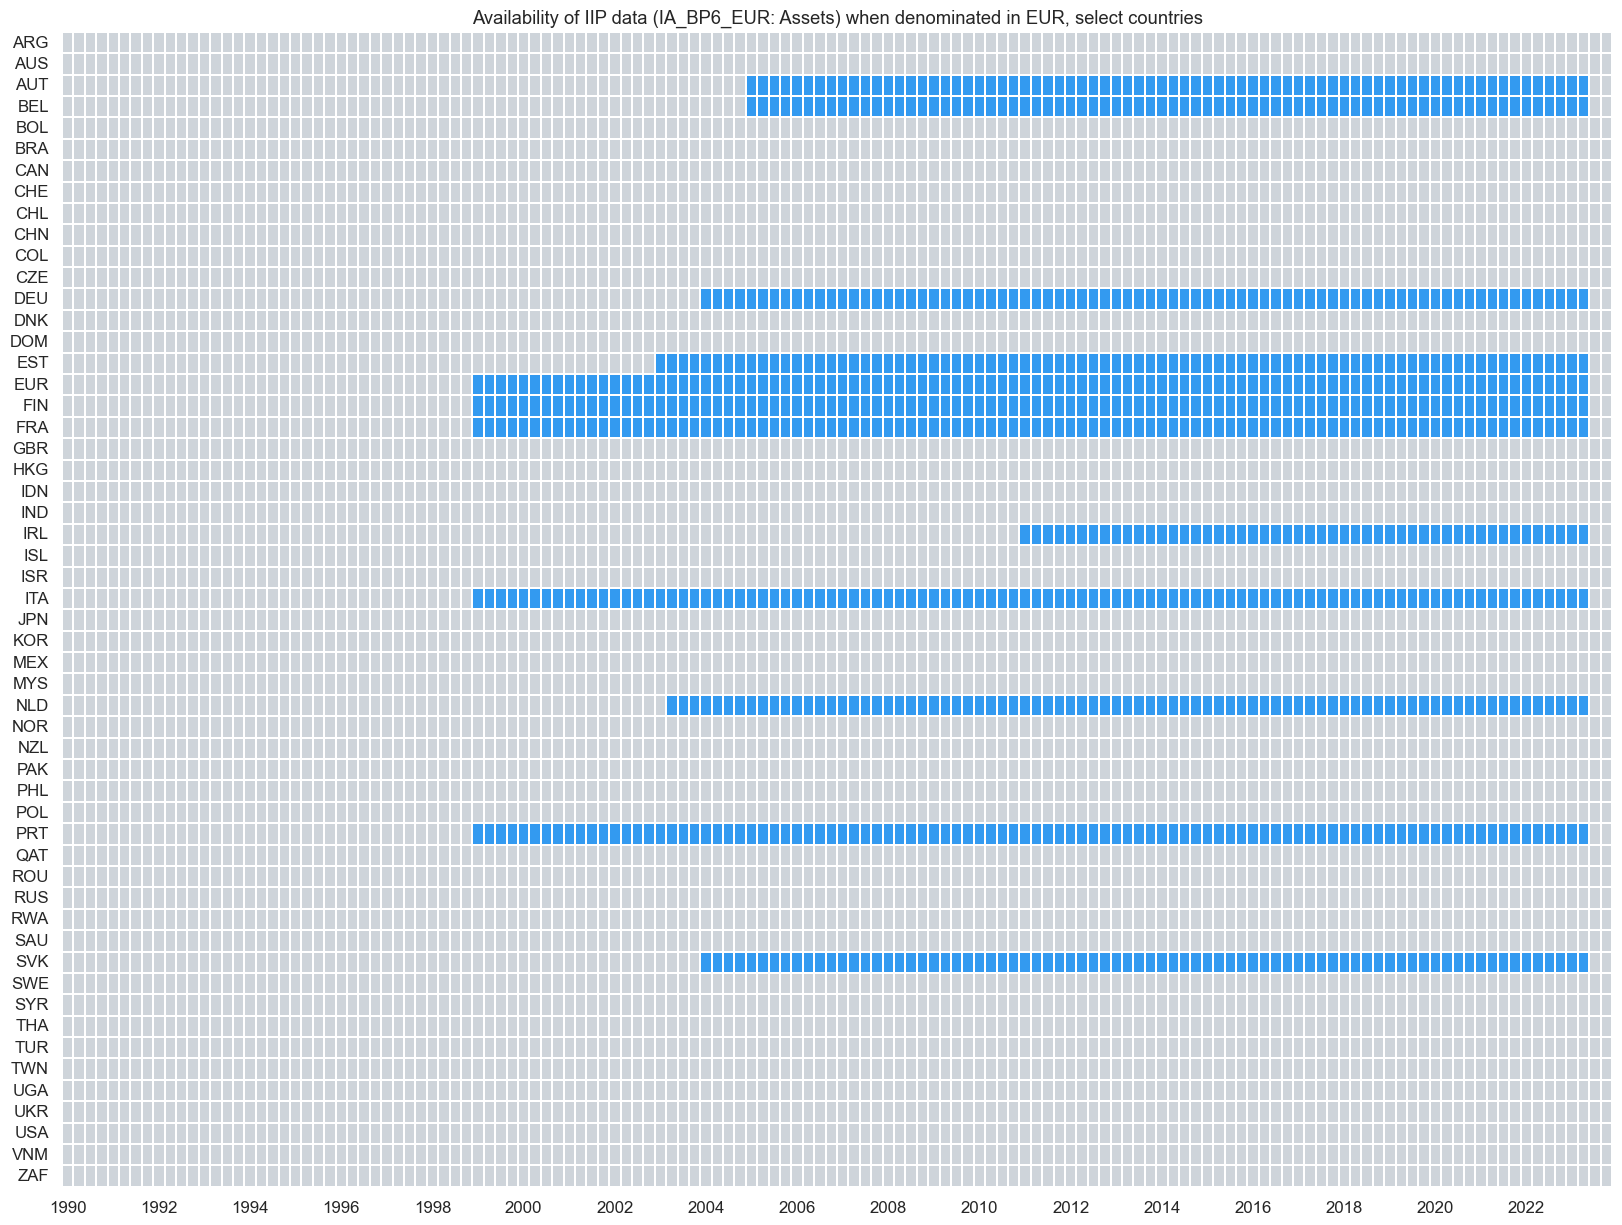

,iso3,date,value
0,AUT,1990-01-31,NaN
1,BEL,1990-01-31,NaN
4,EST,1990-01-31,NaN
6,EUR,1990-01-31,NaN
7,FIN,1990-01-31,NaN
...,...,...,...
9243,ARG,2014-07-31,NaN
9244,ARG,2020-01-31,NaN
9245,ARG,1996-04-30,NaN
9246,ARG,2019-10-31,NaN


In [19]:
filter_data_heatmap(iip_euro_long, 'IA_BP6_EUR')

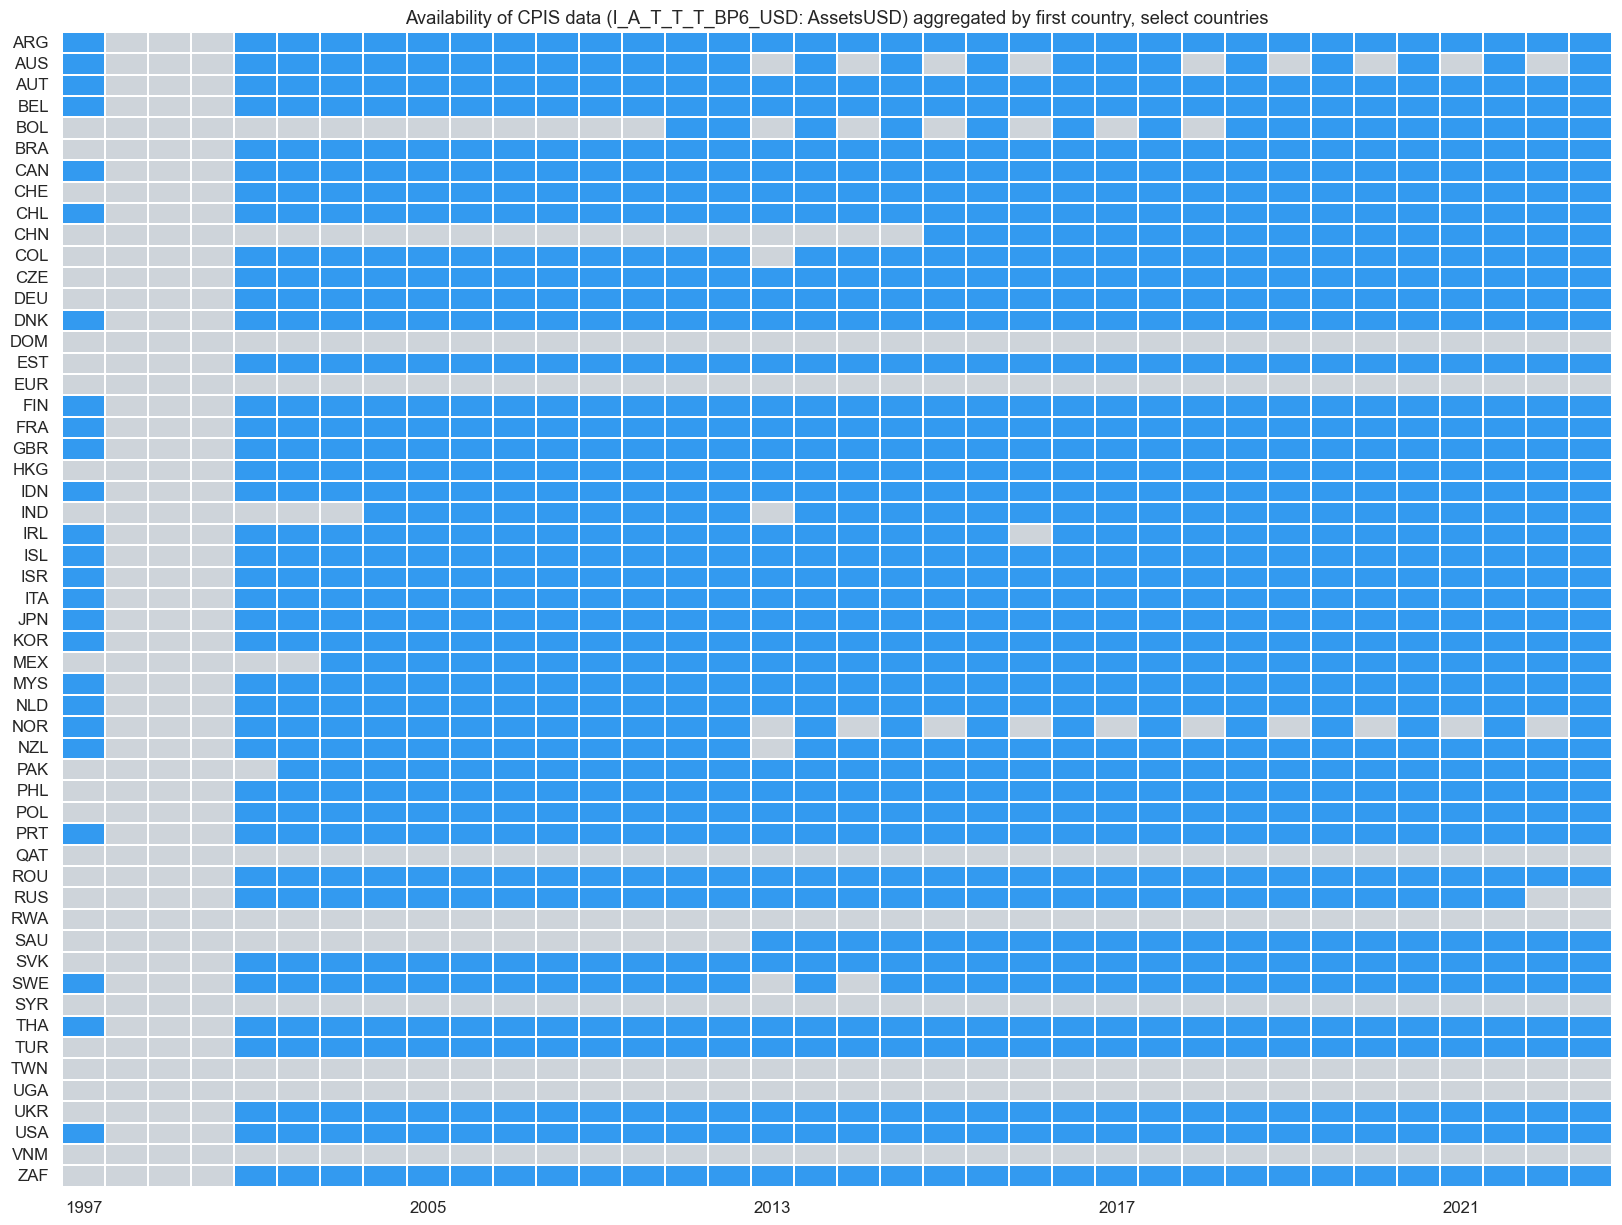

,iso3,date,value
3,SAU,1997-12-31,NaN
4,RUS,1997-12-31,NaN
5,ROU,1997-12-31,NaN
7,PRT,1997-12-31,1.761962e+10
8,POL,1997-12-31,NaN
...,...,...,...
3464,BRA,2022-12-31,4.735572e+10
3465,CHL,2022-12-31,1.230556e+11
3468,SVK,2022-12-31,2.948936e+10
3469,NOR,2022-12-31,1.494894e+12


In [22]:
filter_data_heatmap(cpis_grouped_o, 'I_A_T_T_T_BP6_USD', agg='firstcountry')

a.	Using either the CPIS data (aggregated to the country level) or the International Investment Position data, can you see if the countries with the largest asset positions are those with the lowest interest rates (i.e. US, Japan, Switzerland, Germany)? Can you see what Australia and New Zealand’s Asset positions look like – are they different to these countries materially? Do you see the same patterns if we divide by GDP? Are the patters strongest for gross assets? Net assets? Equity only? Bonds only?

In [24]:
# merging everything

stuff = portfoliodata[(portfoliodata['Date'] >= dt.datetime(1990,1,31)) & (portfoliodata['Date'] <= dt.datetime(2023,4,30))][['iso3', 'gdp', 'shortterm']].groupby('iso3').mean(numeric_only=False)

assetsgross = iip_usd_long[(iip_usd_long['Indicator Code'] == 'IA_BP6_USD') & (iip_usd_long['value'].notnull())][['iso3', 'value']].groupby('iso3').sum(numeric_only=False)
liabilities = iip_usd_long[(iip_usd_long['Indicator Code'] == 'IL_BP6_USD') & (iip_usd_long['value'].notnull())][['iso3', 'value']].groupby('iso3').sum(numeric_only=False)

assetsgross_equities = iip_usd_long[(iip_usd_long['Indicator Code'] == 'IAPE_BP6_USD') & (iip_usd_long['value'].notnull())][['iso3', 'value']].groupby('iso3').sum(numeric_only=False)
assetsgross_securities = iip_usd_long[(iip_usd_long['Indicator Code'] == 'IAPD_BP6_USD') & (iip_usd_long['value'].notnull())][['iso3', 'value']].groupby('iso3').sum(numeric_only=False)

item_a = pd.merge(left=stuff, right=assetsgross, how='inner', on='iso3').dropna()
item_a.rename(columns={'value': 'iip_assetsgross'}, inplace=True)
item_a = pd.merge(left=item_a, right=liabilities, how='inner', on='iso3').dropna()
item_a.rename(columns={'value': 'iip_liabilities'}, inplace=True)
item_a = pd.merge(left=item_a, right=assetsgross_equities, how='inner', on='iso3').dropna()
item_a.rename(columns={'value': 'iip_assetsgross_equities'}, inplace=True)
item_a = pd.merge(left=item_a, right=assetsgross_securities, how='inner', on='iso3').dropna()
item_a.rename(columns={'value': 'iip_assetsgross_securities'}, inplace=True)

item_a['iip_assetsnet'] = item_a['iip_assetsgross'] - item_a['iip_liabilities']

item_a['iip_assetsgross/gdp'] = item_a['iip_assetsgross']/item_a['gdp']
item_a['iip_assetsgross_equities/gdp'] = item_a['iip_assetsgross_equities']/item_a['gdp']
item_a['iip_assetsgross_securities/gdp'] = item_a['iip_assetsgross_securities']/item_a['gdp']


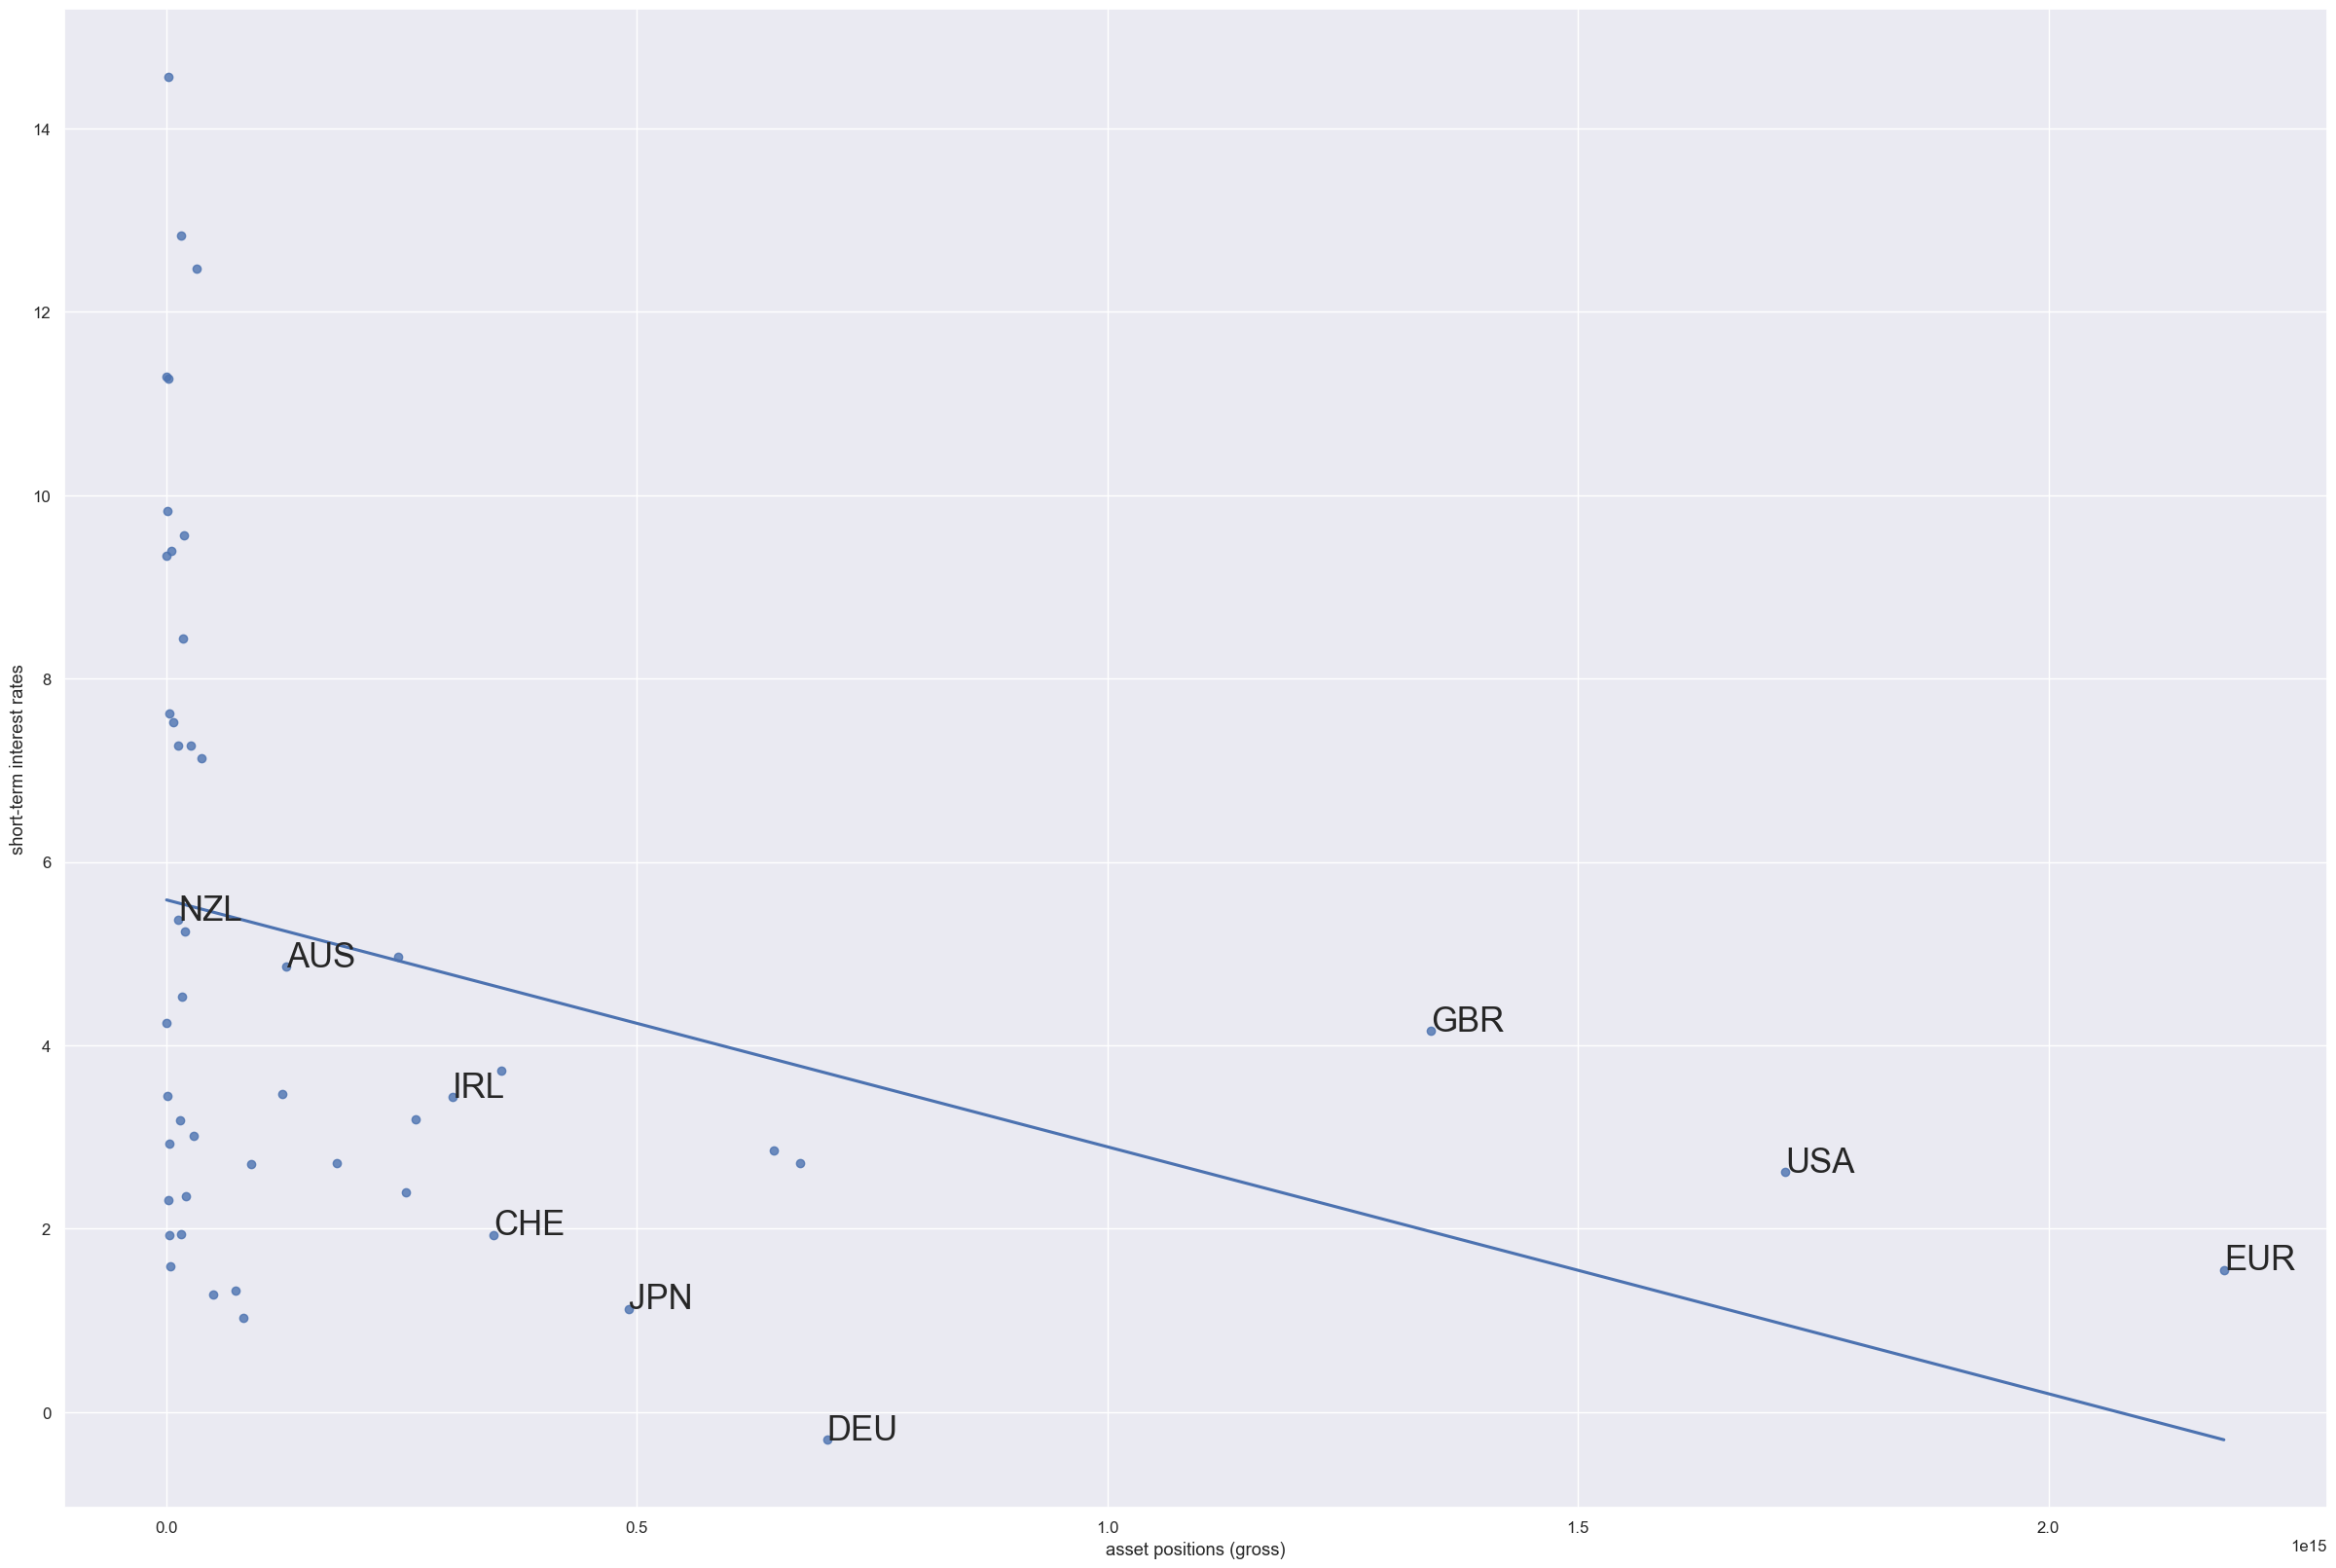

In [25]:
# small scatterplot (gross asset position)

plt.rcParams.update({'font.size': 25})

# open figure + axis
fig = plt.subplots(figsize=(30,20))
# plot
ax = sns.regplot(x=item_a['iip_assetsgross'],y=item_a['shortterm'],ci=None)
# set labels
ax.set_xlabel('asset positions (gross)')
ax.set_ylabel('short-term interest rates')

# annotate points in axis
for idx, row in item_a.iterrows():
    if idx in ['USA', 'GBR', 'JPN', 'EUR', 'DEU', 'IRL', 'CHE', 'AUS', 'NZL']:
        ax.annotate(idx, (row['iip_assetsgross'], row['shortterm']) )

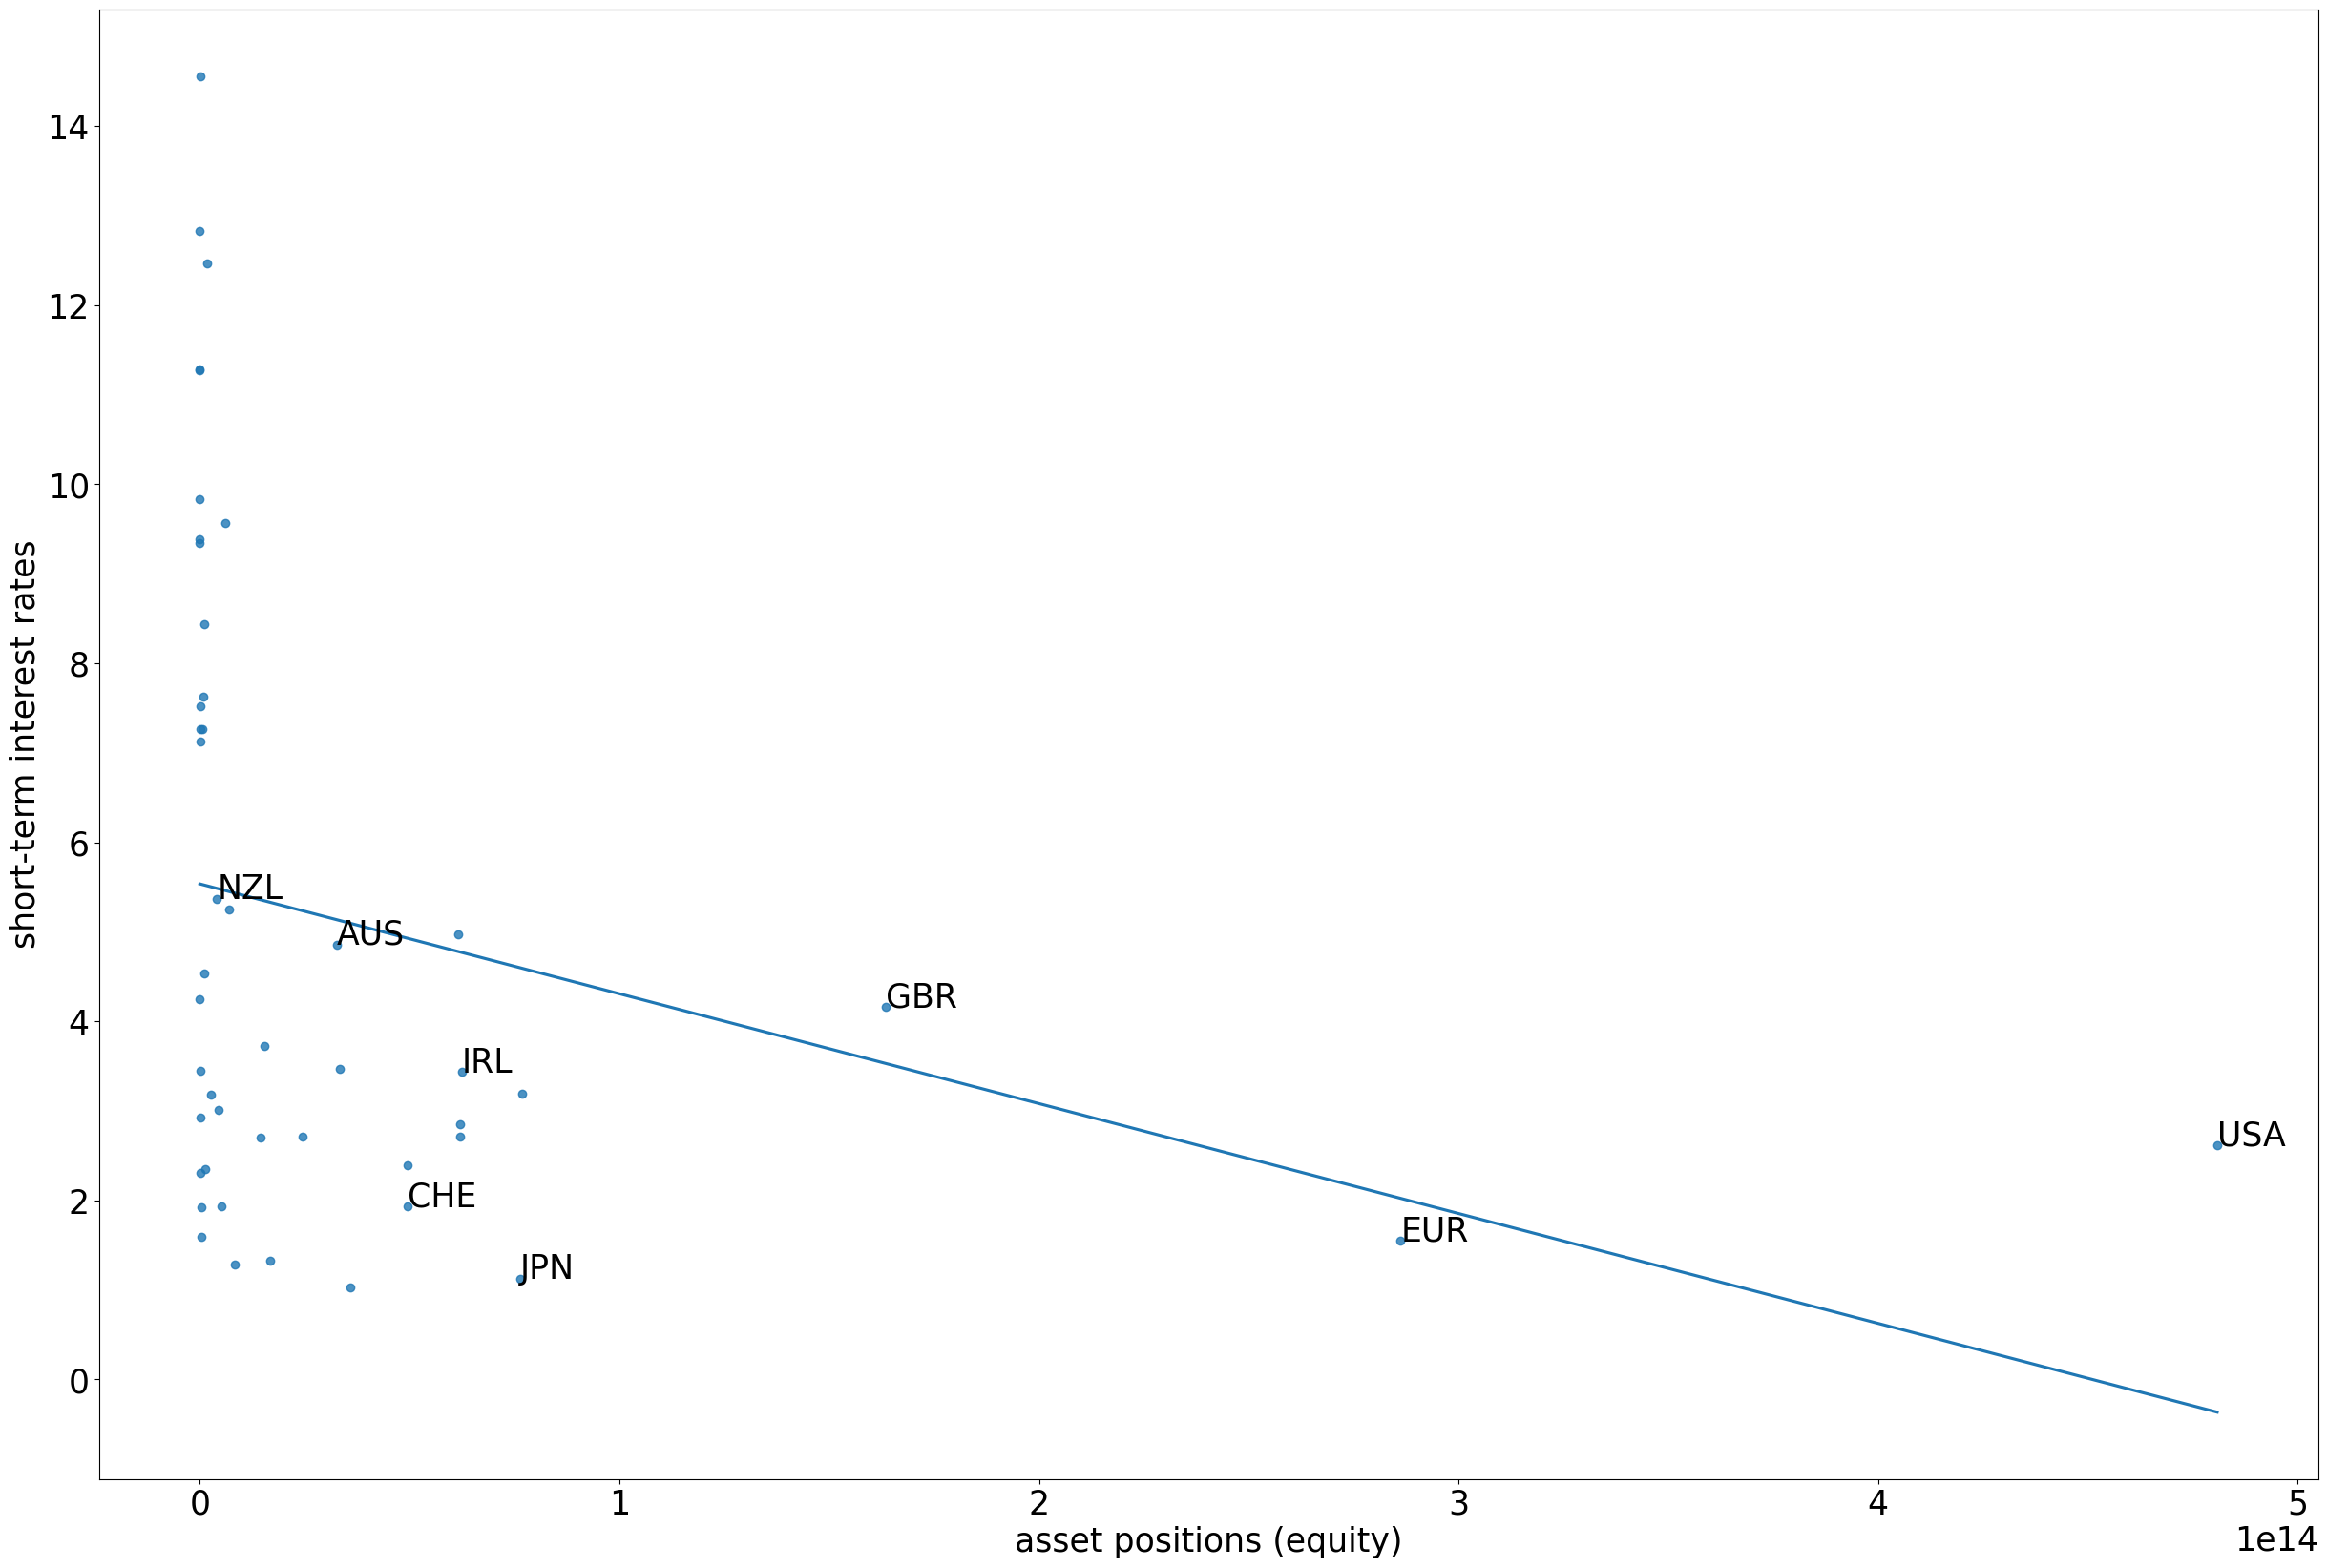

In [25]:
# small scatterplot (equity holdings)

# open figure + axis
fig = plt.subplots(figsize=(30,20))
# plot
ax = sns.regplot(x=item_a['iip_assetsgross_equities'],y=item_a['shortterm'],ci=None)
# set labels
ax.set_xlabel('asset positions (equity)')
ax.set_ylabel('short-term interest rates')

# annotate points in axis
for idx, row in item_a.iterrows():
    if idx in ['USA', 'GBR', 'JPN', 'EUR', 'IRL', 'CHE', 'AUS', 'NZL']:
        ax.annotate(idx, (row['iip_assetsgross_equities'], row['shortterm']) )

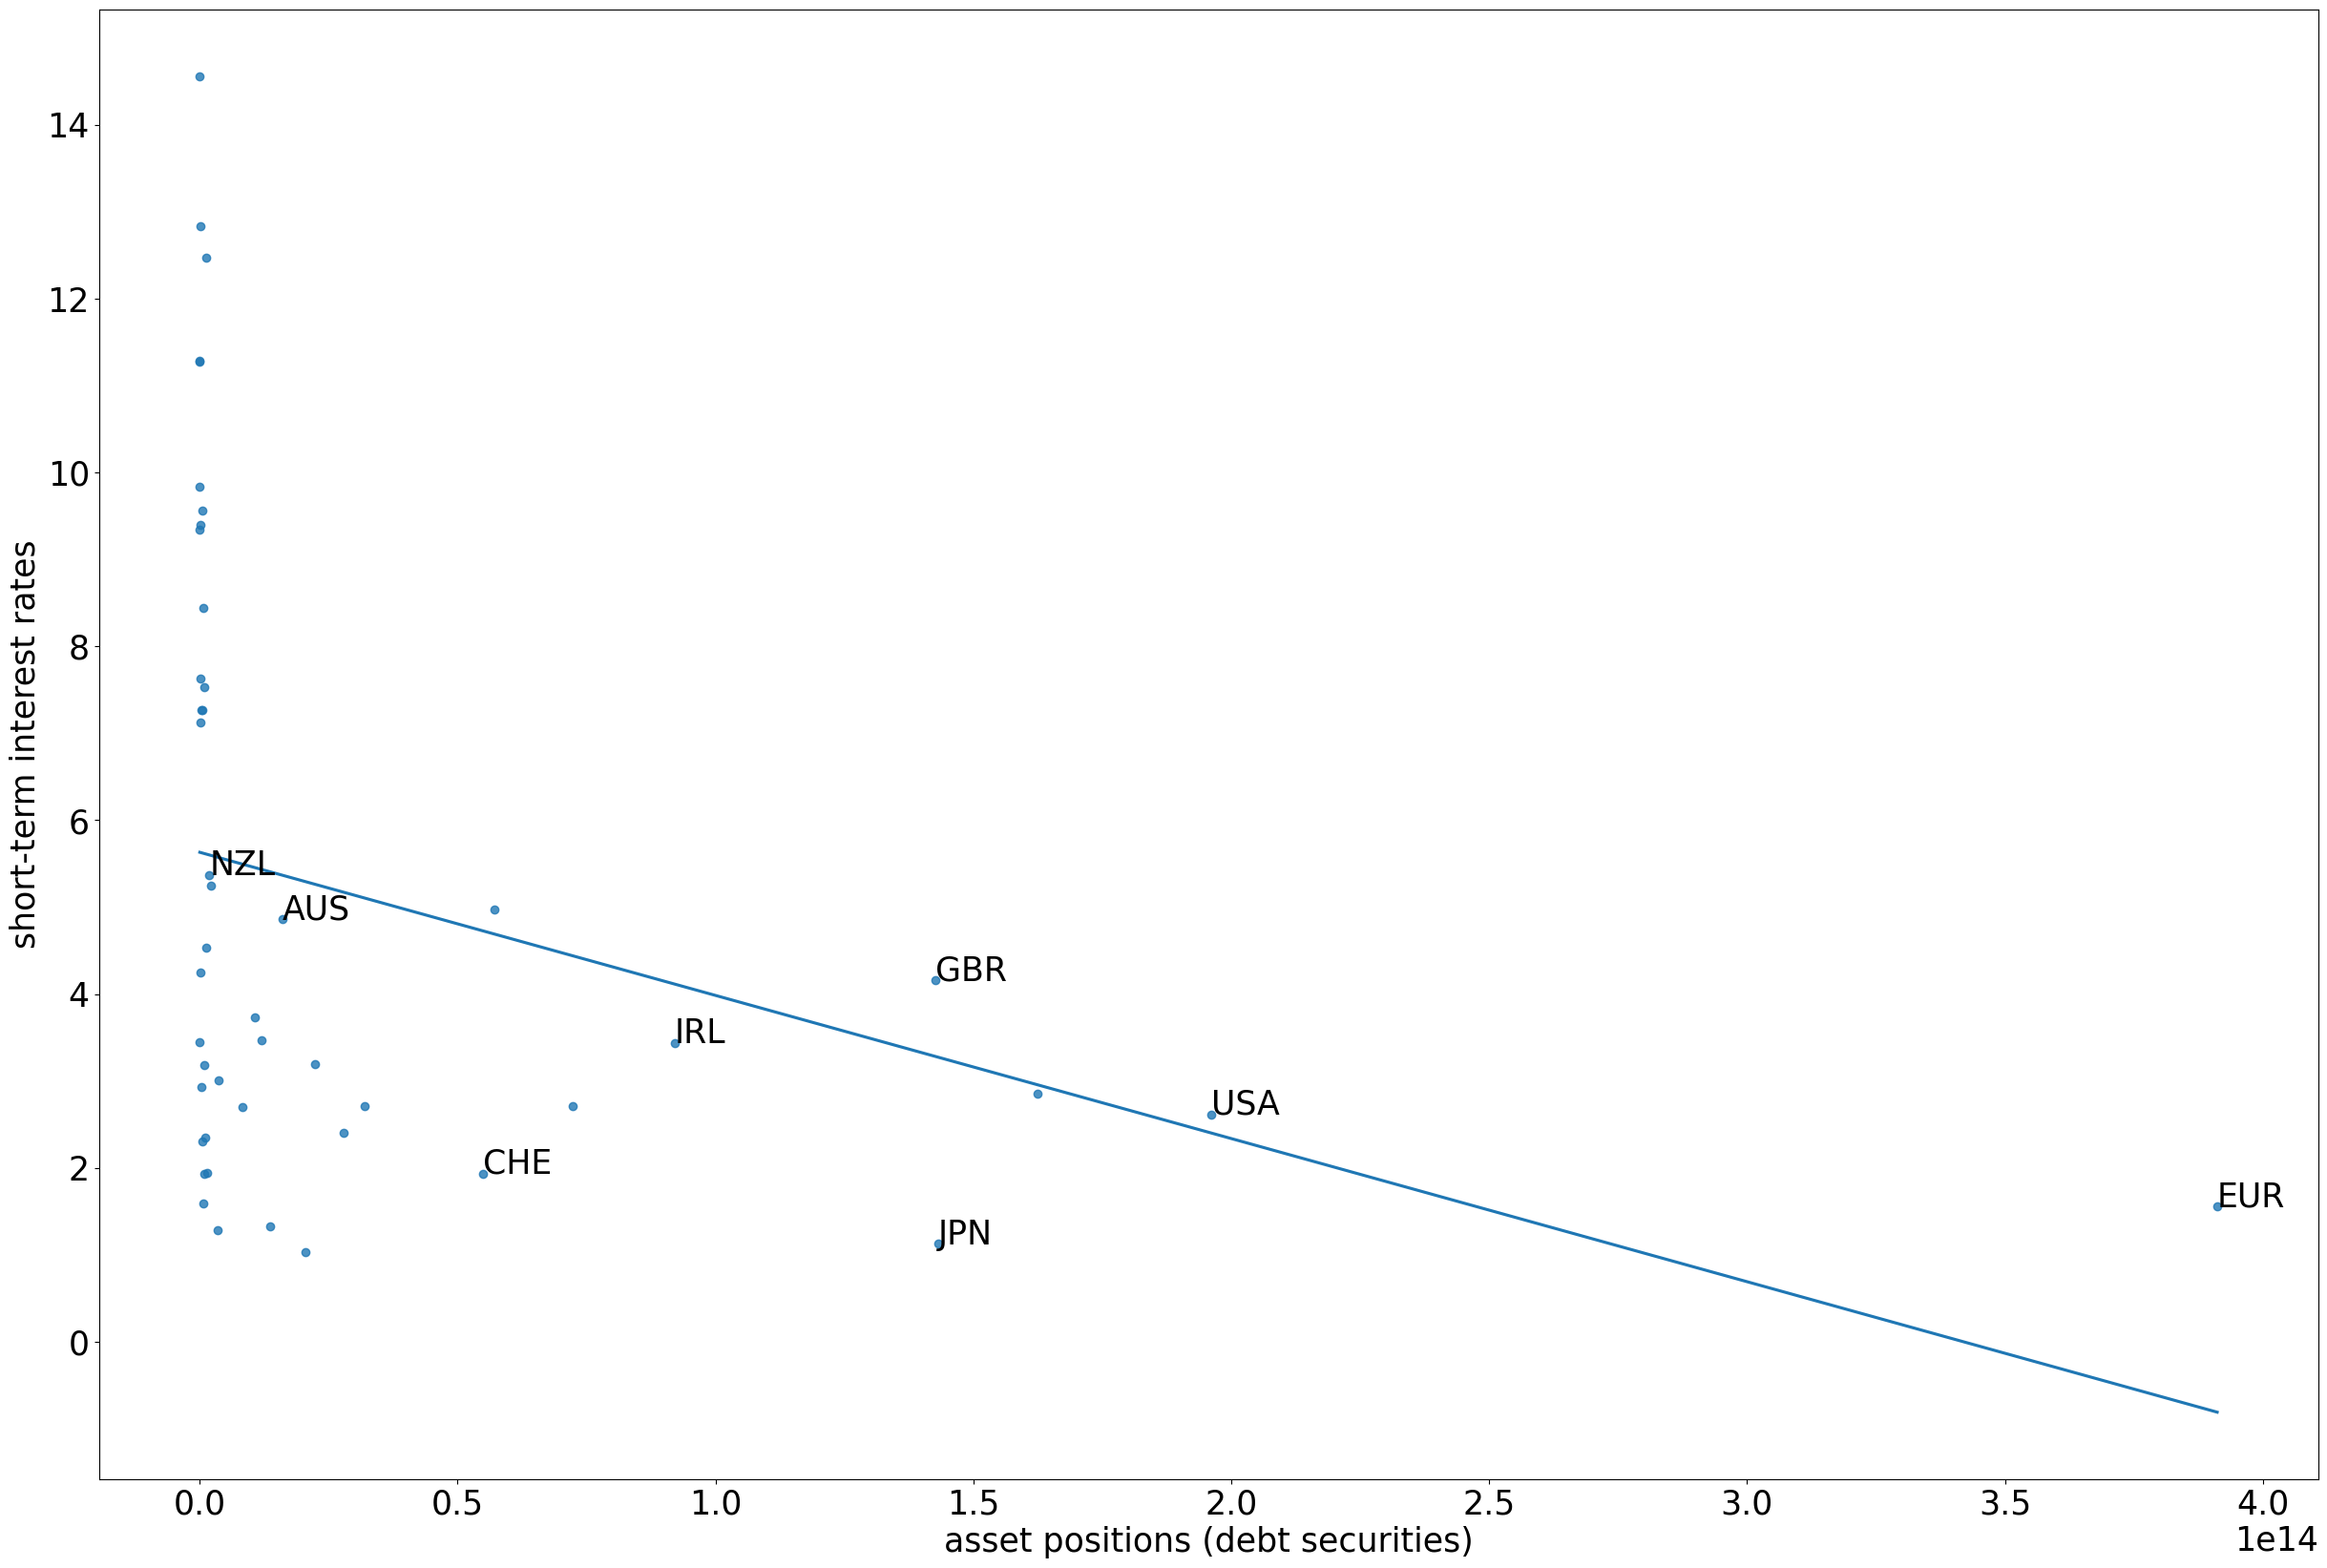

In [26]:
# small scatterplot (debt securities)

# open figure + axis
fig = plt.subplots(figsize=(30,20))
# plot
ax = sns.regplot(x=item_a['iip_assetsgross_securities'],y=item_a['shortterm'],ci=None)
# set labels
ax.set_xlabel('asset positions (debt securities)')
ax.set_ylabel('short-term interest rates')

# annotate points in axis
for idx, row in item_a.iterrows():
    if idx in ['USA', 'GBR', 'JPN', 'EUR', 'IRL', 'CHE', 'AUS', 'NZL']:
        ax.annotate(idx, (row['iip_assetsgross_securities'], row['shortterm']) )

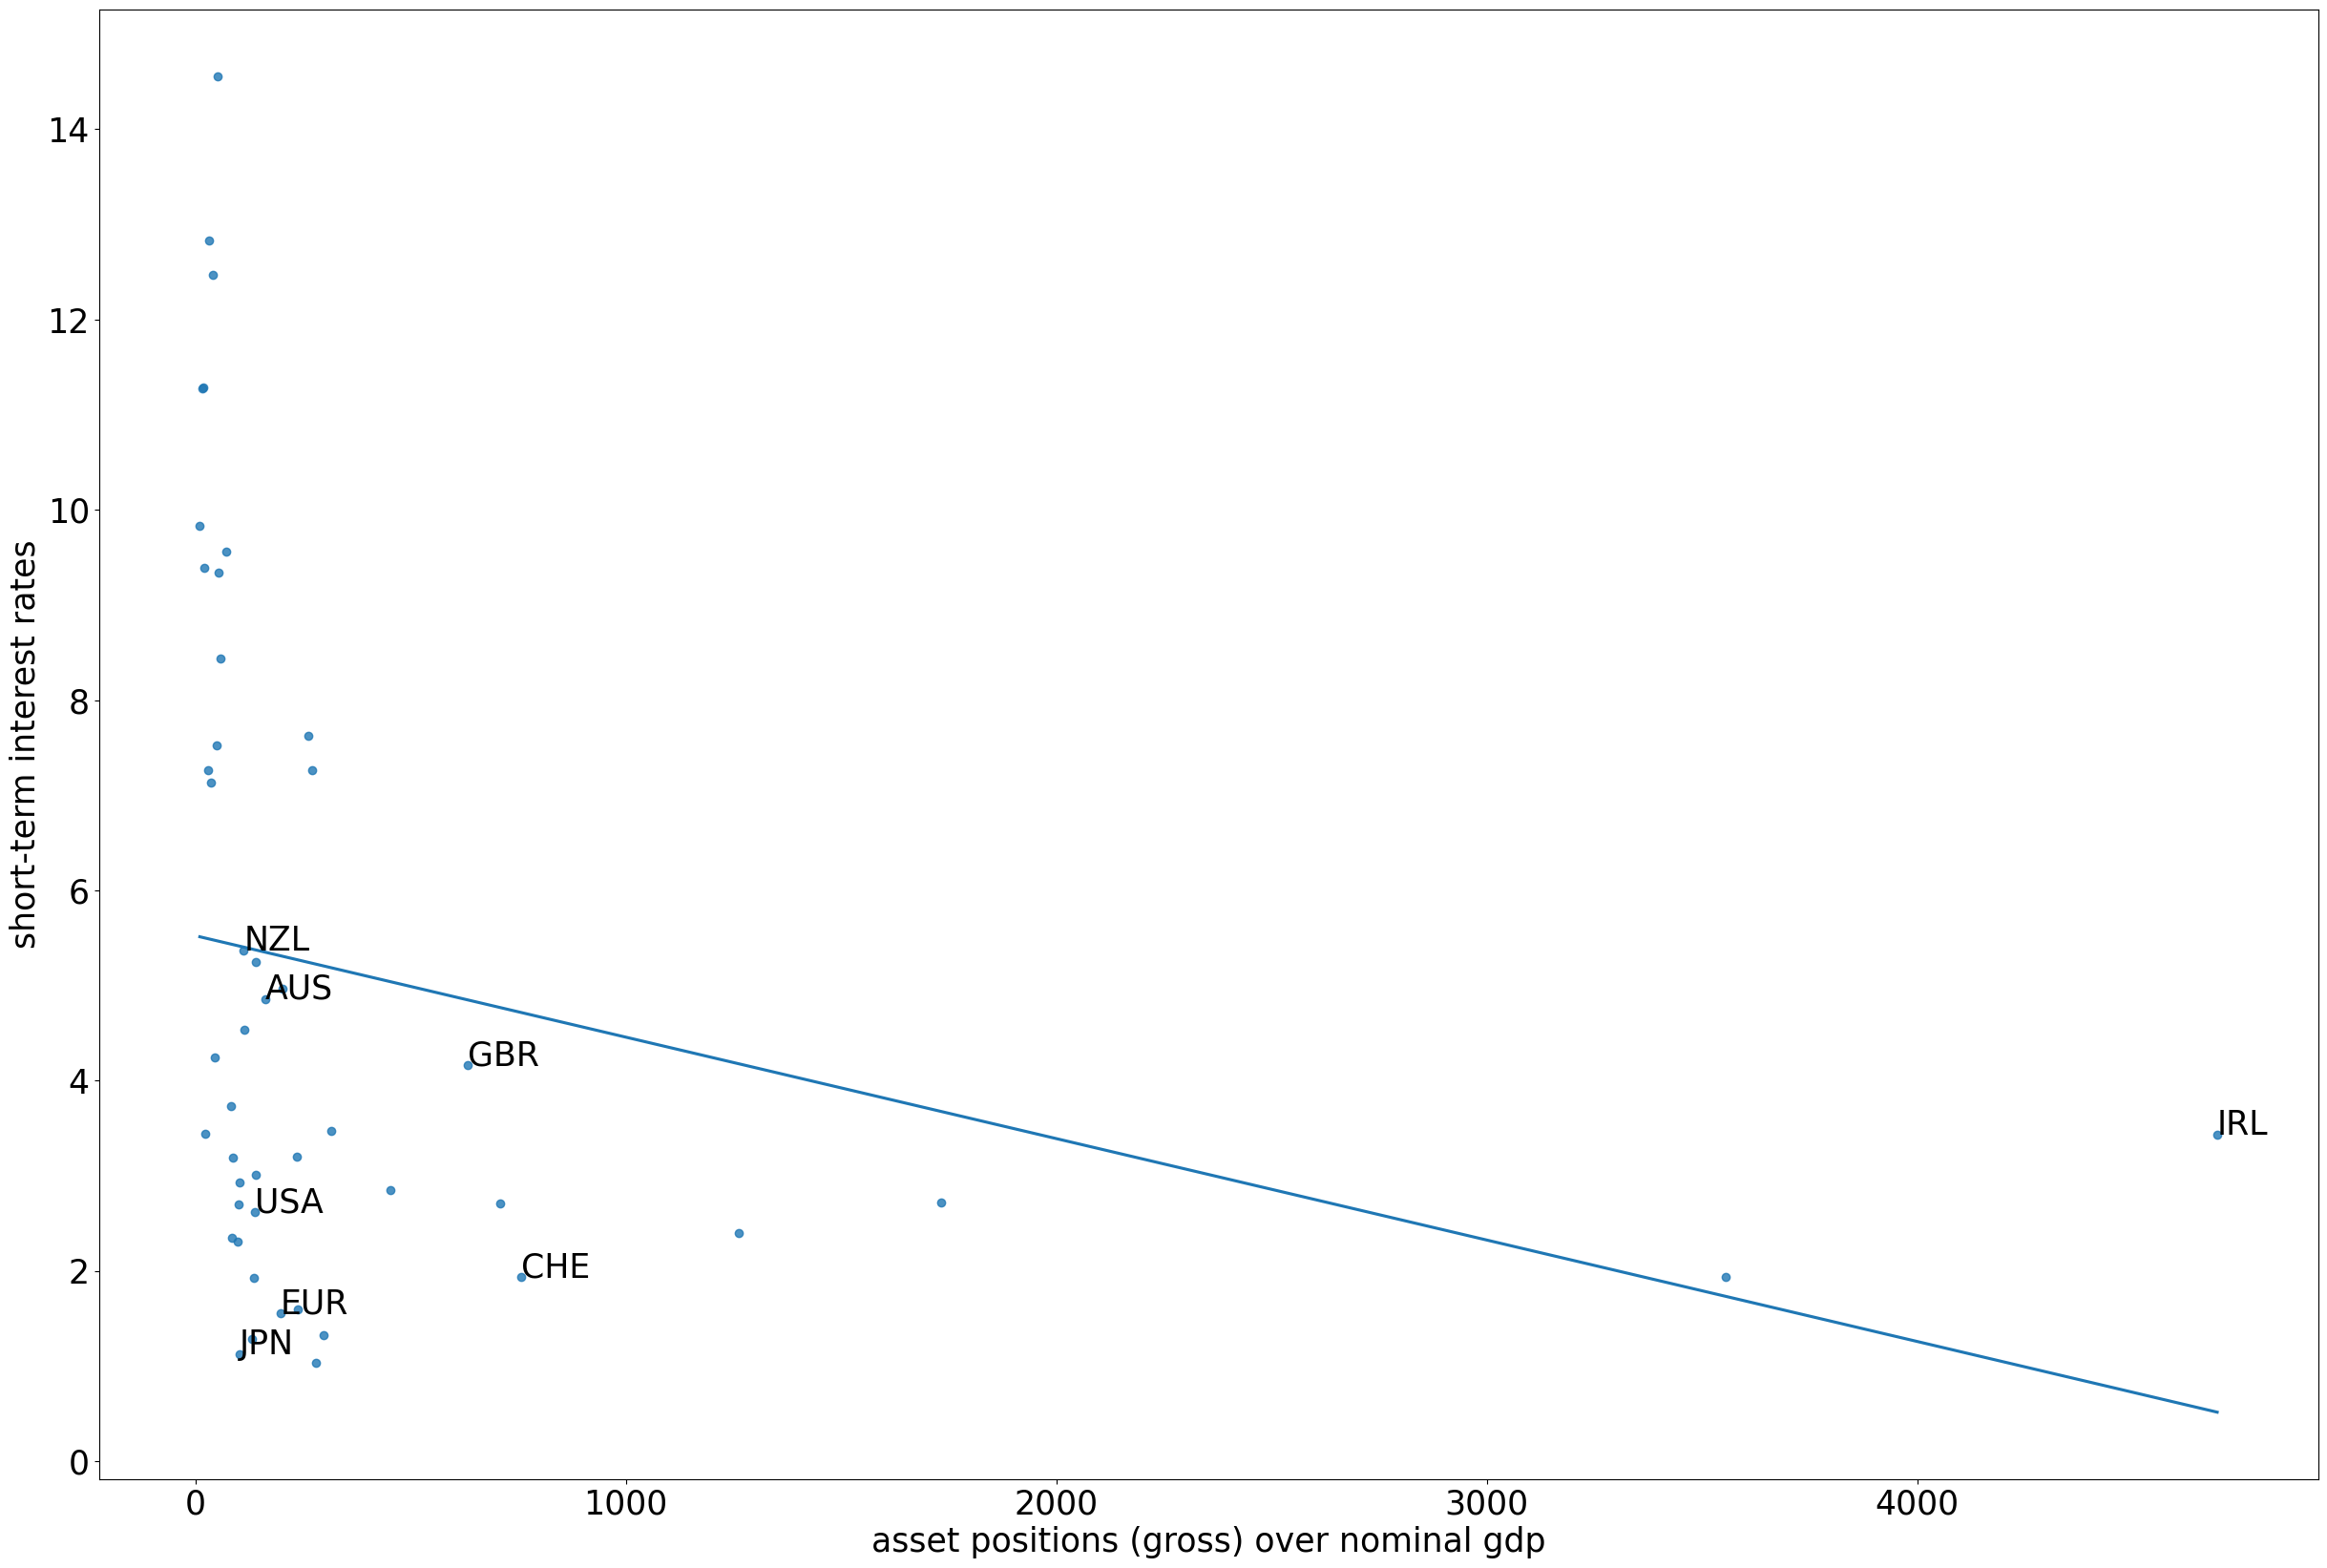

In [27]:
# small scatterplot (gross asset position, dividing by gdp)

# open figure + axis
fig = plt.subplots(figsize=(30,20))
# plot
ax = sns.regplot(x=item_a['iip_assetsgross/gdp'],y=item_a['shortterm'],ci=None)
# set labels
ax.set_xlabel('asset positions (gross) over nominal gdp')
ax.set_ylabel('short-term interest rates')

# annotate points in axis
for idx, row in item_a.iterrows():
    if idx in ['USA', 'GBR', 'JPN', 'EUR', 'IRL', 'CHE', 'AUS', 'NZL']:
        ax.annotate(idx, (row['iip_assetsgross/gdp'], row['shortterm']) )

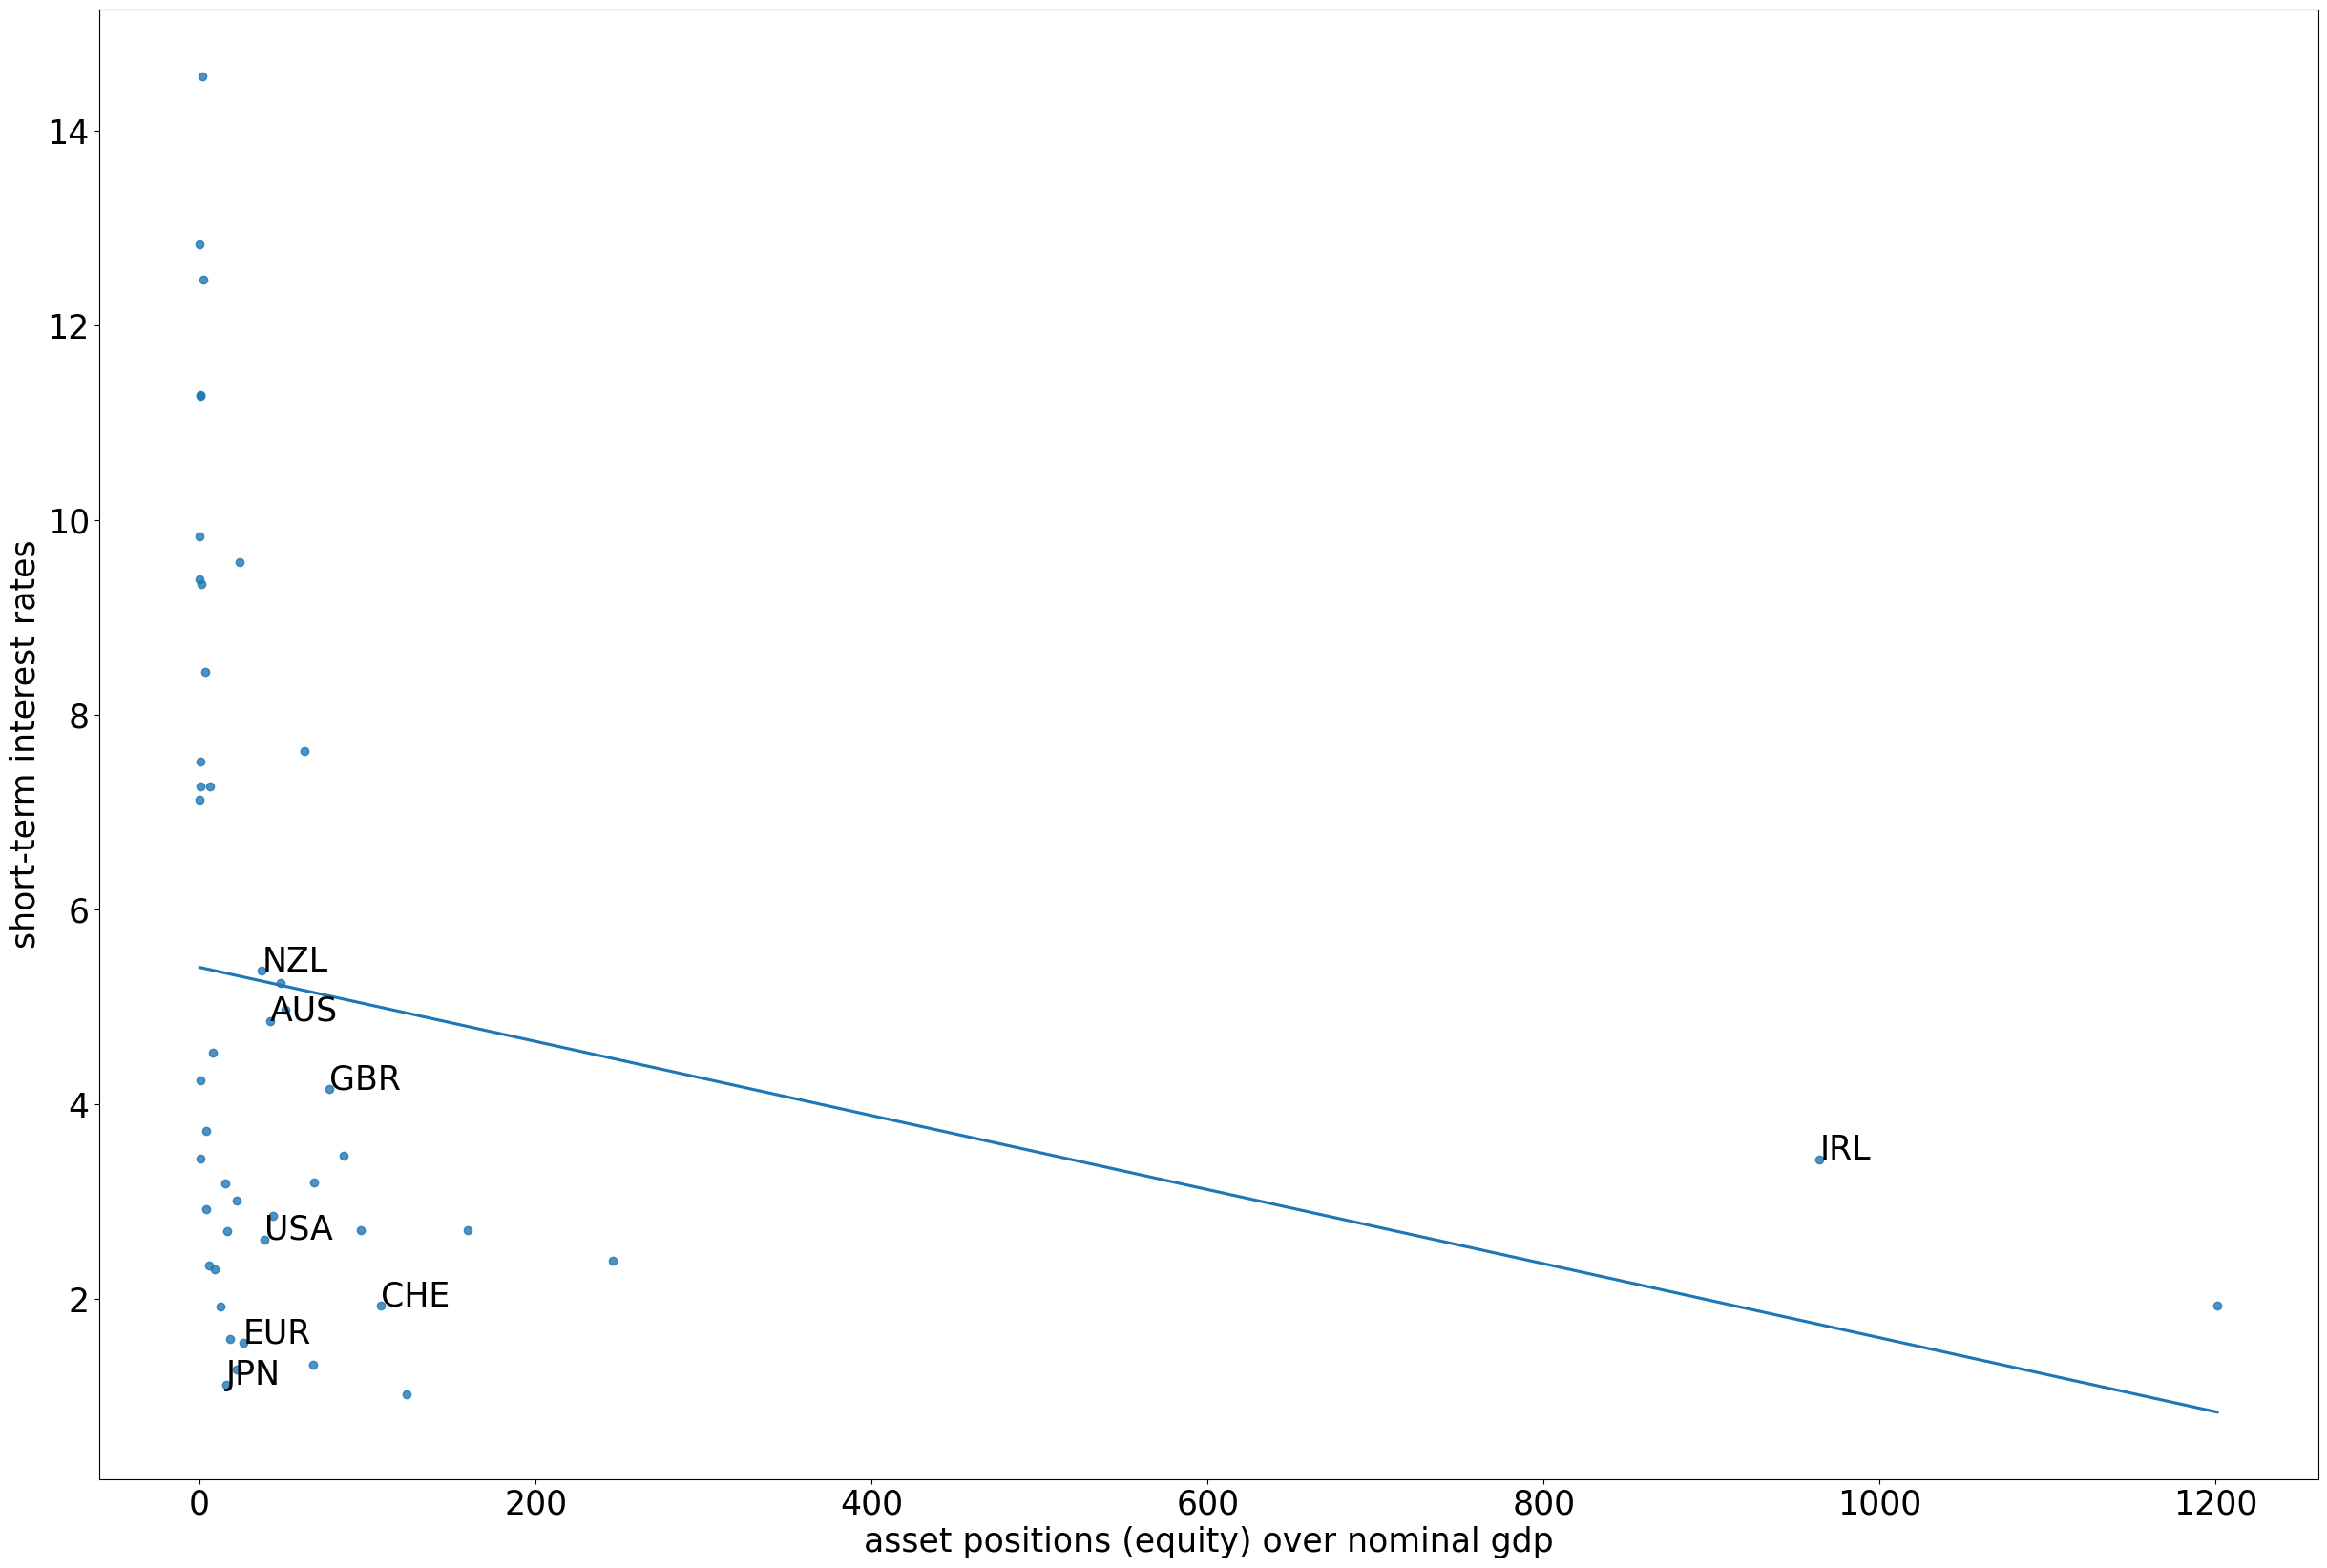

In [28]:
# small scatterplot (equity holdings, dividing by gdp)

# open figure + axis
fig = plt.subplots(figsize=(30,20))
# plot
ax = sns.regplot(x=item_a['iip_assetsgross_equities/gdp'],y=item_a['shortterm'],ci=None)
# set labels
ax.set_xlabel('asset positions (equity) over nominal gdp')
ax.set_ylabel('short-term interest rates')

# annotate points in axis
for idx, row in item_a.iterrows():
    if idx in ['USA', 'GBR', 'JPN', 'EUR', 'IRL', 'CHE', 'AUS', 'NZL']:
        ax.annotate(idx, (row['iip_assetsgross_equities/gdp'], row['shortterm']) )

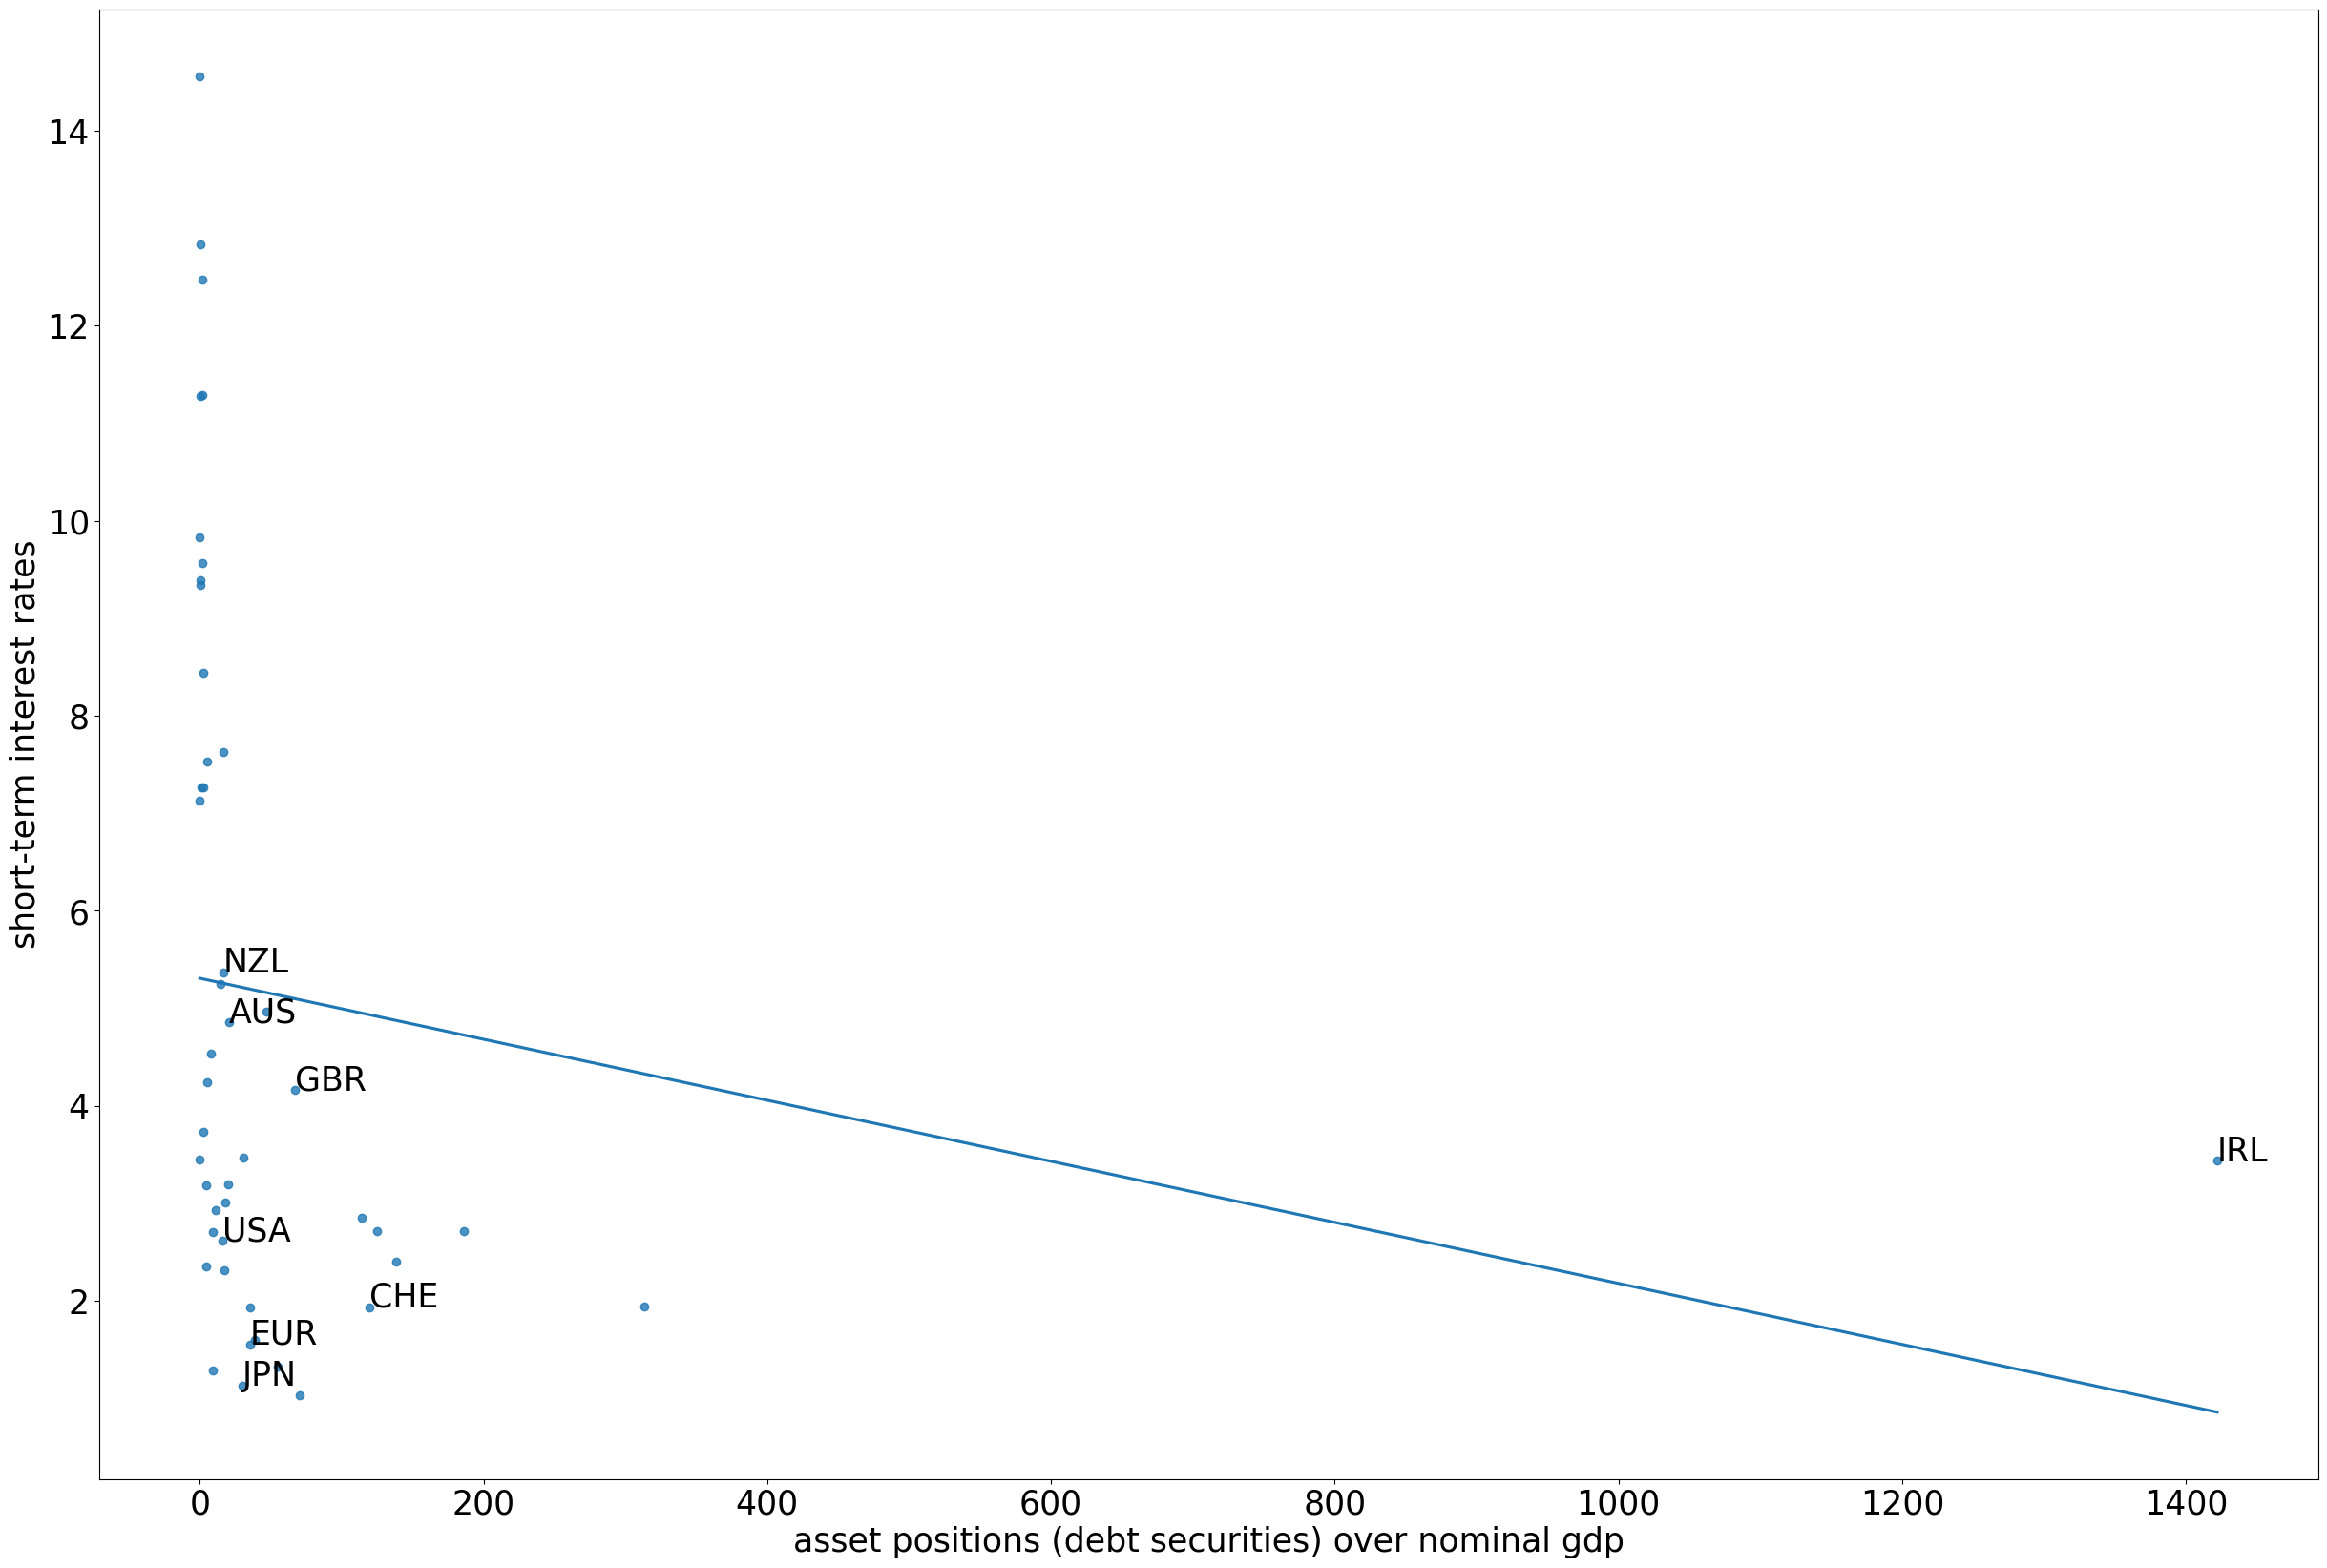

In [29]:
# small scatterplot (debt securities, dividing by gdp)

# open figure + axis
fig = plt.subplots(figsize=(30,20))
# plot
ax = sns.regplot(x=item_a['iip_assetsgross_securities/gdp'],y=item_a['shortterm'],ci=None)
# set labels
ax.set_xlabel('asset positions (debt securities) over nominal gdp')
ax.set_ylabel('short-term interest rates')

# annotate points in axis
for idx, row in item_a.iterrows():
    if idx in ['USA', 'GBR', 'JPN', 'EUR', 'IRL', 'CHE', 'AUS', 'NZL']:
        ax.annotate(idx, (row['iip_assetsgross_securities/gdp'], row['shortterm']) )

b. Do you see big changes in these asset positions around either big risk off dates or when the VIX spikes/Global financial cycle is low? Do the countries with the international largest asset positions have the largest capital inflows in risk off periods?

i.	1997 Asia Crisis

ii.	2008 Financial Crisis: December 2007 to June 2009

iii. 2010 Euro Sovereign Debt Crisis: 2009 to late 2010

iv.	2013 Taper Tantrum: 2013Q2 (ish)

v.	Brexit: 2020Q1 (but referendum in 2016?)

vi.	COVID: 2020Q2

In [40]:
# just look at some time series

# united states
us = iip_usd_long[(iip_usd_long['Indicator Code'].isin(['IA_BP6_USD', 
                                                'IL_BP6_USD', 
                                                'ILPE_BP6_USD', 
                                                'ILPD_BP6_USD', 
                                                'IAPE_BP6_USD', 
                                                'IAPD_BP6_USD'])) & (iip_usd_long['iso3'] == 'USA')][['Indicator Code', 'date', 'value']]

# japan
jp = iip_usd_long[(iip_usd_long['Indicator Code'].isin(['IA_BP6_USD', 
                                                'IL_BP6_USD', 
                                                'ILPE_BP6_USD', 
                                                'ILPD_BP6_USD', 
                                                'IAPE_BP6_USD', 
                                                'IAPD_BP6_USD'])) & (iip_usd_long['iso3'] == 'JPN')][['Indicator Code', 'date', 'value']]

Text(0.5, 1.0, 'total assets (gross, JPN)')

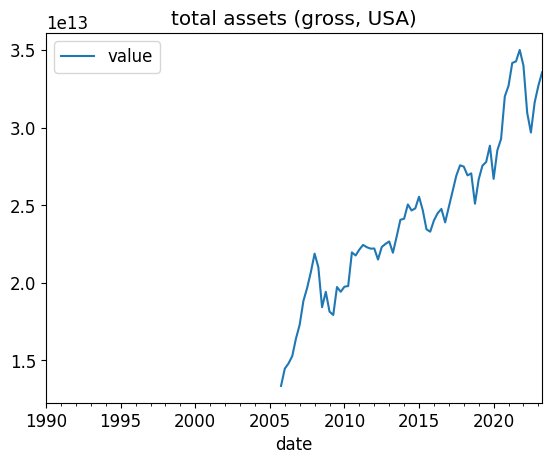

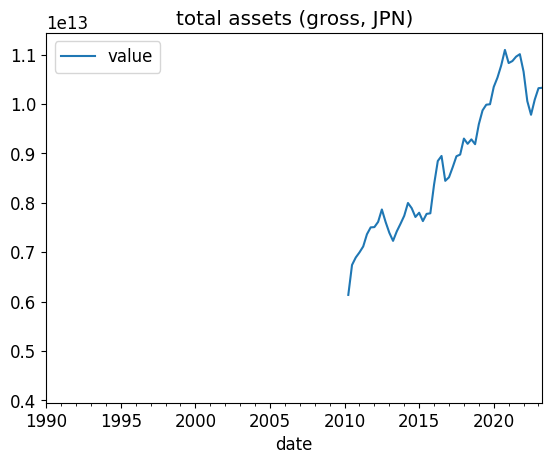

In [41]:
plt.rcParams.update({'font.size': 12})

us[us['Indicator Code'] == 'IA_BP6_USD'].plot(x='date', y='value')
plt.title('total assets (gross, USA)')

jp[jp['Indicator Code'] == 'IA_BP6_USD'].plot(x='date', y='value')
plt.title('total assets (gross, JPN)')